In [1]:
!pip install -q -U watermark

### **Carregando Bibliotecas**

In [2]:
import sklearn
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
%reload_ext watermark
%watermark -a "Salaries Prediction"

Author: Salaries Prediction



### **Carregando os Dados**

In [4]:
# Carregando DataSet
df_data = pd.read_csv('dataset.csv')

In [5]:
# Shape
df_data.shape

(64461, 61)

In [6]:
# Visualizar amostra de dados
df_data.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


### **Engenharia de Atributos e Limpeza de Dados**

In [7]:
# Selecionando as variáveis para construção do modelo:
ds = df_data[["Country", "DevType", "EdLevel", "YearsCodePro", "Employment", "ConvertedComp"]]

In [8]:
# Alterando nome de uma variável:
ds = ds.rename({"ConvertedComp" : "Salary"}, axis = 1)

In [9]:
ds.head()

,Country,DevType,EdLevel,YearsCodePro,Employment,Salary
0,Germany,"Developer, desktop or enterprise applications;...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",27,"Independent contractor, freelancer, or self-em...",NaN
1,United Kingdom,"Developer, full-stack;Developer, mobile","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,Employed full-time,NaN
2,Russian Federation,NaN,NaN,NaN,NaN,NaN
3,Albania,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,NaN,NaN
4,United States,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,Employed full-time,NaN


In [10]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       64072 non-null  object 
 1   DevType       49370 non-null  object 
 2   EdLevel       57431 non-null  object 
 3   YearsCodePro  46349 non-null  object 
 4   Employment    63854 non-null  object 
 5   Salary        34756 non-null  float64
dtypes: float64(1), object(5)
memory usage: 3.0+ MB


In [11]:
ds.isnull().sum()

Country           389
DevType         15091
EdLevel          7030
YearsCodePro    18112
Employment        607
Salary          29705
dtype: int64

In [12]:
# Filtramos os dados mantendo somente valores não nulos
ds = ds[ds["Salary"].notnull()]

In [13]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34756 entries, 7 to 64154
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       34756 non-null  object 
 1   DevType       34367 non-null  object 
 2   EdLevel       34188 non-null  object 
 3   YearsCodePro  34621 non-null  object 
 4   Employment    34717 non-null  object 
 5   Salary        34756 non-null  float64
dtypes: float64(1), object(5)
memory usage: 1.9+ MB


In [14]:
# Eliminando registros com valores ausentes
ds = ds.dropna()

In [15]:
# Verificando se sobrou valores ausentes:
ds.isnull().sum()

Country         0
DevType         0
EdLevel         0
YearsCodePro    0
Employment      0
Salary          0
dtype: int64

### **Verificando Variáveis**

In [16]:
# Valores únicos da variável categórica:
ds['Employment'].unique()

array(['Employed full-time',
       'Independent contractor, freelancer, or self-employed',
       'Employed part-time'], dtype=object)

In [17]:
# Contando registros por categoria:
ds['Employment'].value_counts()

Employment
Employed full-time                                      29722
Independent contractor, freelancer, or self-employed     2977
Employed part-time                                        997
Name: count, dtype: int64

In [18]:
# Vamos manter somente os registros de quem trabalha full-time:
ds = ds[ds["Employment"] == "Employed full-time"]

In [19]:
ds.head()

,Country,DevType,EdLevel,YearsCodePro,Employment,Salary
7,United States,"Developer, back-end;Developer, desktop or ente...","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",13,Employed full-time,116000.0
9,United Kingdom,"Database administrator;Developer, full-stack;D...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,Employed full-time,32315.0
10,United Kingdom,"Developer, back-end;Developer, desktop or ente...","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",2,Employed full-time,40070.0
11,Spain,"Designer;Developer, front-end",Some college/university study without earning ...,7,Employed full-time,14268.0
12,Netherlands,"Designer;Developer, back-end","Secondary school (e.g. American high school, G...",20,Employed full-time,38916.0


In [20]:
# Não precisamos mais desta variável pois ela é uma constante:
ds = ds.drop("Employment", axis = 1)

In [21]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29722 entries, 7 to 64154
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       29722 non-null  object 
 1   DevType       29722 non-null  object 
 2   EdLevel       29722 non-null  object 
 3   YearsCodePro  29722 non-null  object 
 4   Salary        29722 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.4+ MB


In [22]:
# Valores únicos da variável:
ds["DevType"].unique()

array(['Developer, back-end;Developer, desktop or enterprise applications;Developer, game or graphics',
       'Database administrator;Developer, full-stack;Developer, mobile',
       'Developer, back-end;Developer, desktop or enterprise applications;Developer, embedded applications or devices;Developer, front-end',
       ...,
       'Developer, back-end;Developer, front-end;Developer, full-stack;DevOps specialist;Engineer, data;Engineering manager',
       'Database administrator;Developer, back-end;Developer, desktop or enterprise applications;Developer, front-end;Developer, full-stack;Engineer, data;Engineering manager;System administrator',
       'Developer, full-stack;Developer, QA or test;System administrator'],
      dtype=object)

In [23]:
# Convertendo a variável em uma lista fazendo split por ;
ds['DevType'] = ds['DevType'].str.split(";")

In [24]:
# Buscando o primeiro elemento da lista:
ds["DevType"] = ds["DevType"].str[0]

In [25]:
# Valores únicos:
len(ds['DevType'].unique())

23

In [26]:
ds["DevType"].value_counts()

DevType
Developer, back-end                              11763
Developer, full-stack                             3849
Database administrator                            2155
Developer, front-end                              1997
Data or business analyst                          1870
Academic researcher                               1769
Designer                                          1438
Developer, desktop or enterprise applications     1324
Data scientist or machine learning specialist     1142
Developer, mobile                                  826
Developer, embedded applications or devices        526
DevOps specialist                                  255
Developer, QA or test                              204
Engineer, data                                     129
Engineering manager                                114
Developer, game or graphics                        104
System administrator                                72
Engineer, site reliability                          47
Se

In [27]:
# Definição da função que recebe duas entradas: 'categories', que é uma série de dados categóricos, 
# e 'cutoff', que é um limite númerico:
def reduz_categorias(categories, cutoff):
    
    # Inicializa um dicionário vazio para mapear as categorias
    categorical_map = {}
    
    # Inicia um loop que percorre todos os elementos da série 'categories'
    for i in range(len(categories)):
        
        # Verifica se o valor da categoria atual é maior ou igual ao limite (cutoff).
        if categories.values[i] >= cutoff:
            
            # Se verdadeiro, mapeia a categoria para ela mesma no dicionário.
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            
            # Se falso, mapeia a categoria para 'Other'.
            categorical_map[categories.index[i]] = 'Other'
    
    # Após o loop, retorna o dicionário com o mapeamento das categorias.
    return categorical_map

In [28]:
# Aplicando nossa função para uma variável do DataSet
dev_map = reduz_categorias(ds['DevType'].value_counts(), 100)

In [29]:
# Agora mapeamos o item anterior ao valor atual da variável e salvamos na própria variável:
ds["DevType"] = ds["DevType"].map(dev_map)

In [30]:
ds["DevType"].value_counts()

DevType
Developer, back-end                              11763
Developer, full-stack                             3849
Database administrator                            2155
Developer, front-end                              1997
Data or business analyst                          1870
Academic researcher                               1769
Designer                                          1438
Developer, desktop or enterprise applications     1324
Data scientist or machine learning specialist     1142
Developer, mobile                                  826
Developer, embedded applications or devices        526
Other                                              257
DevOps specialist                                  255
Developer, QA or test                              204
Engineer, data                                     129
Engineering manager                                114
Developer, game or graphics                        104
Name: count, dtype: int64

In [31]:
ds["Country"].value_counts()

Country
United States     7468
India             2409
United Kingdom    2247
Germany           1891
Canada            1161
                  ... 
Benin                1
Fiji                 1
San Marino           1
Guinea               1
Andorra              1
Name: count, Length: 154, dtype: int64

In [32]:
country_map = reduz_categorias(ds['Country'].value_counts(), 400)

In [33]:
ds["Country"] = ds["Country"].map(country_map)

In [34]:
ds["Country"].value_counts()

Country
Other                 8482
United States         7468
India                 2409
United Kingdom        2247
Germany               1891
Canada                1161
Brazil                 985
France                 966
Spain                  666
Australia              650
Netherlands            648
Poland                 564
Italy                  556
Russian Federation     521
Sweden                 508
Name: count, dtype: int64

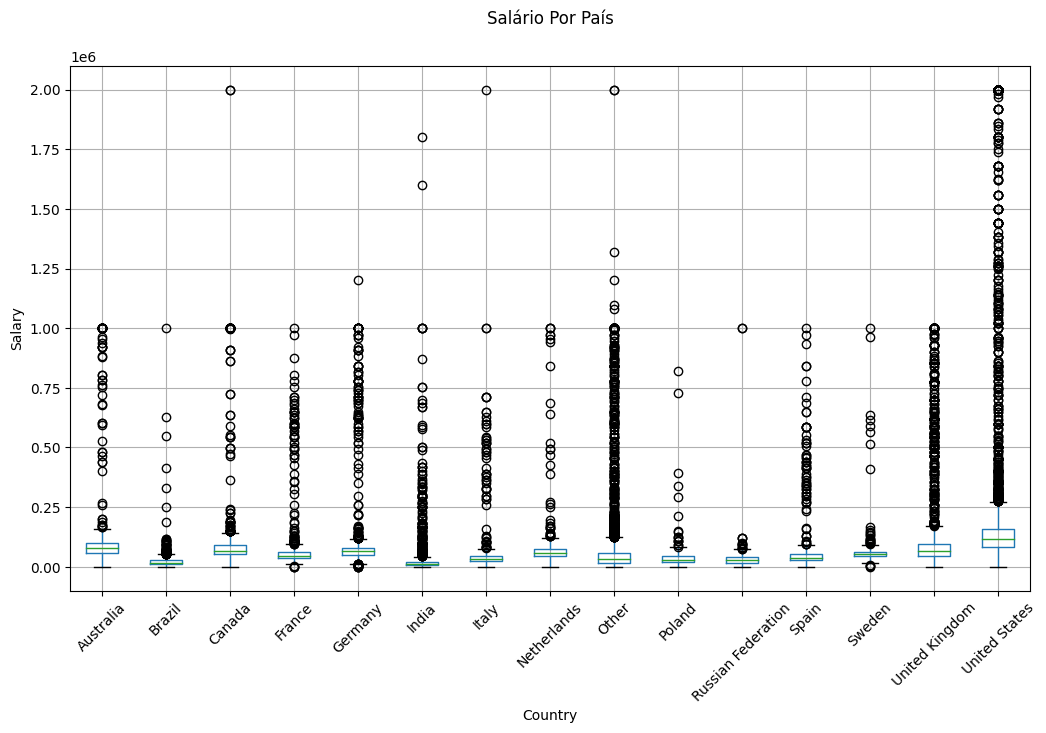

In [35]:
# Plot 
fig, ax = plt.subplots(1,1, figsize = (12, 7))
ds.boxplot('Salary', 'Country', ax = ax)
plt.suptitle('Salário Por País')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation = 45)
plt.show()

In [36]:
# Vamos aplicar mais um filtro aos dados removendo outliers e categorias do tipo "Outros"
ds = ds[ds['Salary'] <= 250000]
ds = ds[ds['Salary'] >= 5000]
ds = ds[ds['Country'] != 'Other']
ds = ds[ds['DevType'] != 'Other']
ds = ds[ds['DevType'] != 'Other (please specify):']

In [37]:
ds.shape

(19047, 5)

In [38]:
ds.head()

,Country,DevType,EdLevel,YearsCodePro,Salary
7,United States,"Developer, back-end","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",13,116000.0
9,United Kingdom,Database administrator,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,32315.0
10,United Kingdom,"Developer, back-end","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",2,40070.0
11,Spain,Designer,Some college/university study without earning ...,7,14268.0
12,Netherlands,Designer,"Secondary school (e.g. American high school, G...",20,38916.0


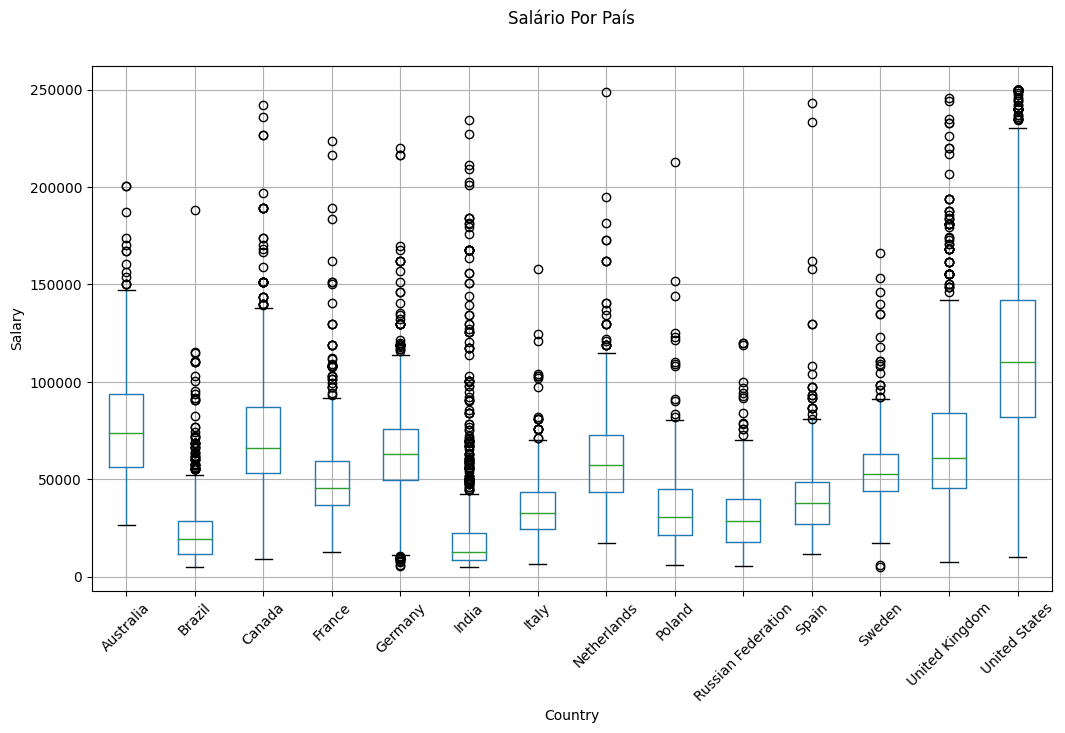

In [39]:
# Plot 
fig, ax = plt.subplots(1,1, figsize = (12, 7))
ds.boxplot('Salary', 'Country', ax = ax)
plt.suptitle('Salário Por País')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation = 45)
plt.show()

In [40]:
# Valores únicos
ds["YearsCodePro"].unique()

array(['13', '4', '2', '7', '20', '1', '3', '10', '12', '29', '6', '28',
       '8', '23', '15', '25', '9', '11', 'Less than 1 year', '5', '21',
       '16', '18', '14', '32', '19', '22', '38', '30', '26', '27', '17',
       '24', '34', '35', '33', '36', '40', '39', 'More than 50 years',
       '31', '37', '41', '45', '42', '44', '43', '50', '49'], dtype=object)

In [41]:
# Função para converter valores incorretos na Variável Anos de Xp
def ajusta_temp_xp(x):
    if x == 'Less than 1 year':
        return 0.5
    if x == 'More than 50 years':
        return 50
    return float(x)

In [42]:
# Aplicando a Function:
ds['YearsCodePro'] = ds['YearsCodePro'].apply(ajusta_temp_xp)

In [43]:
ds['YearsCodePro'].unique()

array([13. ,  4. ,  2. ,  7. , 20. ,  1. ,  3. , 10. , 12. , 29. ,  6. ,
       28. ,  8. , 23. , 15. , 25. ,  9. , 11. ,  0.5,  5. , 21. , 16. ,
       18. , 14. , 32. , 19. , 22. , 38. , 30. , 26. , 27. , 17. , 24. ,
       34. , 35. , 33. , 36. , 40. , 39. , 50. , 31. , 37. , 41. , 45. ,
       42. , 44. , 43. , 49. ])

In [44]:
ds['EdLevel'].unique()

array(['Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Some college/university study without earning a degree',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Associate degree (A.A., A.S., etc.)',
       'Professional degree (JD, MD, etc.)',
       'Other doctoral degree (Ph.D., Ed.D., etc.)',
       'I never completed any formal education',
       'Primary/elementary school'], dtype=object)

In [45]:
def ajusta_educacao(x):
    if 'Bachelor’s degree' in x:
        return 'Bachelor’s degree'
    if 'Master’s degree' in x:
        return 'Master’s degree'
    if 'Professional degree' in x or 'Other doctoral' in x:
        return 'Post grad'
    return 'Less than a Bachelors'

In [46]:
ds['EdLevel'] = ds['EdLevel'].apply(ajusta_educacao)

In [47]:
ds['EdLevel'].value_counts()

EdLevel
Bachelor’s degree        9592
Master’s degree          4899
Less than a Bachelors    3599
Post grad                 957
Name: count, dtype: int64

In [48]:
ds.isnull().sum()

Country         0
DevType         0
EdLevel         0
YearsCodePro    0
Salary          0
dtype: int64

In [49]:
ds.head()

,Country,DevType,EdLevel,YearsCodePro,Salary
7,United States,"Developer, back-end",Bachelor’s degree,13.0,116000.0
9,United Kingdom,Database administrator,Master’s degree,4.0,32315.0
10,United Kingdom,"Developer, back-end",Bachelor’s degree,2.0,40070.0
11,Spain,Designer,Less than a Bachelors,7.0,14268.0
12,Netherlands,Designer,Less than a Bachelors,20.0,38916.0


In [50]:
# Mapeamento para converter a variável categórica em representação númerica:
map_ed_level = {'Less than a Bachelors': 0,
                'Bachelor’s degree': 1,
                'Master’s degree': 2,
                'Post grad': 3}

In [51]:
# Aplica o mapeamento:
ds['EdLevel'] = ds['EdLevel'].map(map_ed_level)

In [52]:
map_pais = {'Other': 0,
            'United States': 1,
            'India': 2,
            'United Kingdom': 3,
            'Germany': 4,
            'Canada': 5,
            'Brazil': 6,
            'France': 7,
            'Spain': 8,
            'Australia': 9,
            'Netherlands': 10,
            'Poland': 11,
            'Italy': 12,
            'Russian Federation': 13,
            'Sweden': 14}

In [53]:
# Aplica o mapeamento:
ds['Country'] = ds['Country'].map(map_pais)

In [54]:
ds.isnull().sum()

Country         0
DevType         0
EdLevel         0
YearsCodePro    0
Salary          0
dtype: int64

In [55]:
ds.head()

,Country,DevType,EdLevel,YearsCodePro,Salary
7,1,"Developer, back-end",1,13.0,116000.0
9,3,Database administrator,2,4.0,32315.0
10,3,"Developer, back-end",1,2.0,40070.0
11,8,Designer,0,7.0,14268.0
12,10,Designer,0,20.0,38916.0


In [56]:
map_dev_type = {'Developer, back-end': 0,
                'Developer, full-stack': 1,
                'Database administrator': 2,
                'Developer, front-end': 3,
                'Data or business analyst': 4,
                'Academic researcher': 5,
                'Designer': 6,
                'Developer, desktop or enterprise applications': 7,
                'Data scientist or machine learning specialist': 8,
                'Developer, mobile': 9,
                'Developer, embedded applications or devices': 10,
                'Other': 11,
                'DevOps specialist': 12,
                'Developer, QA or test': 13,
                'Engineer, data': 14,
                'Engineering manager': 15,
                'Developer, game or graphics': 16}

In [57]:
ds['DevType'] = ds['DevType'].map(map_dev_type)

In [58]:
ds.head()

,Country,DevType,EdLevel,YearsCodePro,Salary
7,1,0,1,13.0,116000.0
9,3,2,2,4.0,32315.0
10,3,0,1,2.0,40070.0
11,8,6,0,7.0,14268.0
12,10,6,0,20.0,38916.0


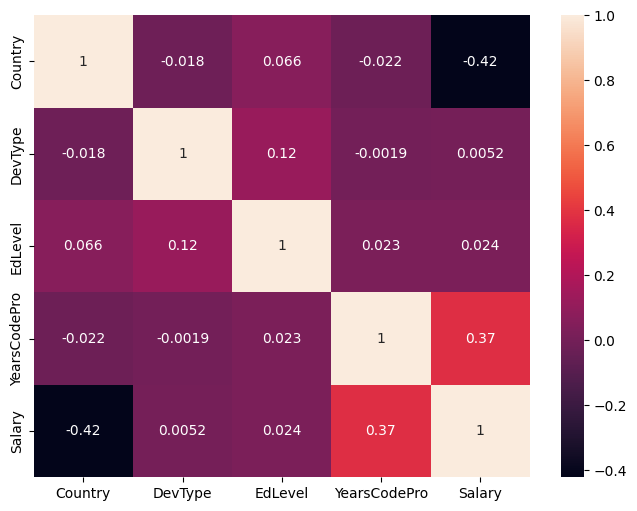

In [59]:
# Mapa de Correlação
plt.figure(figsize = (8,6))
corr = ds.corr()
sns.heatmap(corr, annot = True);

### Pré-Processameto dos Dados:

In [60]:
# Separamos X e Y
X = ds.drop("Salary", axis = 1)
y = ds['Salary']

In [61]:
# Divisão em treino e teste:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [62]:
print(f'Shape de X_treino: {X_treino.shape}\nShape de X_teste: {X_teste.shape}')
print(f'Shape de y_treino: {y_treino.shape}\nShape de X_teste: {y_teste.shape}')

Shape de X_treino: (15237, 4)
Shape de X_teste: (3810, 4)
Shape de y_treino: (15237,)
Shape de X_teste: (3810,)


In [63]:
# Cria o padronizador
scaler = StandardScaler()

In [64]:
# Fit e transform
X_treino_scaled = scaler.fit_transform(X_treino)

In [65]:
# Transform em teste (e em novos dados)
X_teste_scaled = scaler.transform(X_teste)

In [66]:
# Salva o padronizador pois será usado na app
pickle.dump(scaler, open('dsam_scaler.pkl', 'wb'))

In [67]:
X_treino_scaled

array([[-0.87563519, -0.51026172, -0.21064541, -0.88242237],
       [-0.35240715, -0.51026172, -0.21064541,  0.30086836],
       [-0.87563519, -0.51026172, -0.21064541, -1.07963749],
       ...,
       [-0.09079313, -0.80479739, -1.48278339, -0.75094562],
       [-0.35240715,  0.37334526, -0.21064541, -0.88242237],
       [ 2.26373304,  1.25695225, -0.21064541, -1.01389912]])

In [68]:
X_teste_scaled

array([[ 1.47889098, -0.80479739, -0.21064541,  0.56382186],
       [-0.35240715, -0.21572606, -1.48278339,  0.16939162],
       [ 2.26373304,  1.55148791,  1.06149257,  0.03791487],
       ...,
       [-0.87563519,  1.55148791,  1.06149257,  3.06188007],
       [-0.35240715, -0.80479739, -0.21064541, -0.48799212],
       [-0.87563519,  0.0788096 ,  1.06149257, -0.75094562]])

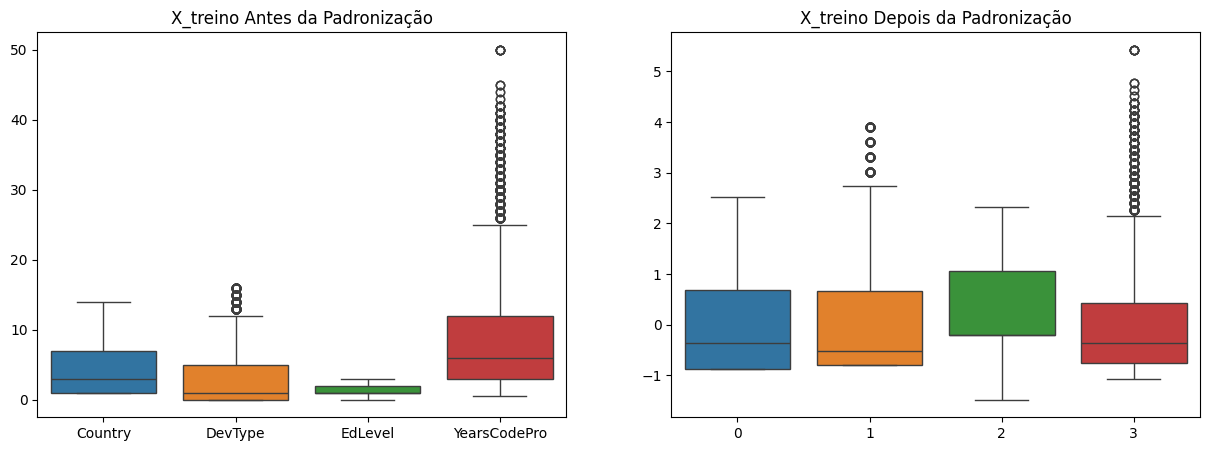

In [69]:
# Cria uma figura e um conjunto de subplots.
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

# Primeiro subplot para X_train antes da padronização 
sns.boxplot(data = X_treino, ax = ax[0])
ax[0].set_title('X_treino Antes da Padronização')

# Segundo subplot para X_train antes da padronização 
sns.boxplot(data = X_treino_scaled, ax = ax[1])
ax[1].set_title('X_treino Depois da Padronização')

plt.show()

## Modelagem Preditiva

### Versão 1 do Modelo:

In [ ]:
# Criar o modelo:
modelo_v1 = LinearRegression()